In [ ]:
reset

In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import netCDF4 as nc
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import metpy.calc as mp
from metpy.units import units
from datetime import datetime

import seaborn as sns
import cartopy
cartopy.config['data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
cartopy.config['pre_existing_data_dir'] = "/discover/nobackup/projects/jh_tutorials/JH_examples/JH_datafiles/Cartopy"
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

from matplotlib import transforms
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cmocean
import cmocean.cm as cmo



In [4]:
## Load Output

# top level data directory
dpath0='/discover/nobackup/projects/giss/baldwin_nip/dmkumar'

# topo BC names
sourceIDs=['CTRL', 'MAX', 'P$_{85}$', 'P$_{80}$', '1.5$\\sigma$-ENV','1$\\sigma$-ENV', '1$\\sigma$-ENV-CAM']

# Obs
frObs=xr.open_dataset(f'{dpath0}/obs_data/froude.etopo05.nc').froude

# E2.1
frGiss=xr.open_dataset(f'{dpath0}/output/froude.e2.1.topo.nc').froude.assign_coords(source_id=sourceIDs)

# E2.1 Ocean Mask
ocn_mask=xr.open_dataset(f'{dpath0}/topo_files/Z2HX2fromZ1QX1N.BS1.nc').fgrnd.sel(lat=slice(-55,25), lon=slice(-110,-60))

# MERRA-2 winds
l1=6 # 850 mb
dpath=f'{dpath0}/obs_data/merra2'
um=xr.open_dataset(f'{dpath}/merra2.U.1980-2022.monthly.nc').U[:,l1].groupby("time.month").mean() 
vm=xr.open_dataset(f'{dpath}/merra2.V.1980-2022.monthly.nc').V[:,l1].groupby("time.month").mean()

In [6]:
u=um.mean(dim='month')
v=vm.mean(dim='month')

In [9]:
## regrid model froude values to E2.1 grid
frGiss_lowres=frGiss.interp(lat=ocn_mask.lat, lon=ocn_mask.lon).sel(lat=slice(-55,25), lon=slice(-110,-60))

# keep only Froude values above critical value (>1)
ones=xr.ones_like(frGiss_lowres)
frGiss_idx=frGiss_lowres.where(frGiss_lowres>=1, np.nan)

# mask ocean cells
frGiss_idx=frGiss_idx.where(ocn_mask>0.25,np.nan)
frGiss_lowres=frGiss_lowres.where(ocn_mask>0.25,np.nan)

## Index Obs Froude
# keep only Froude values above critical value (>1)
ones=xr.ones_like(frObs)
frObs_idx=frObs.where(frObs>=1, np.nan)

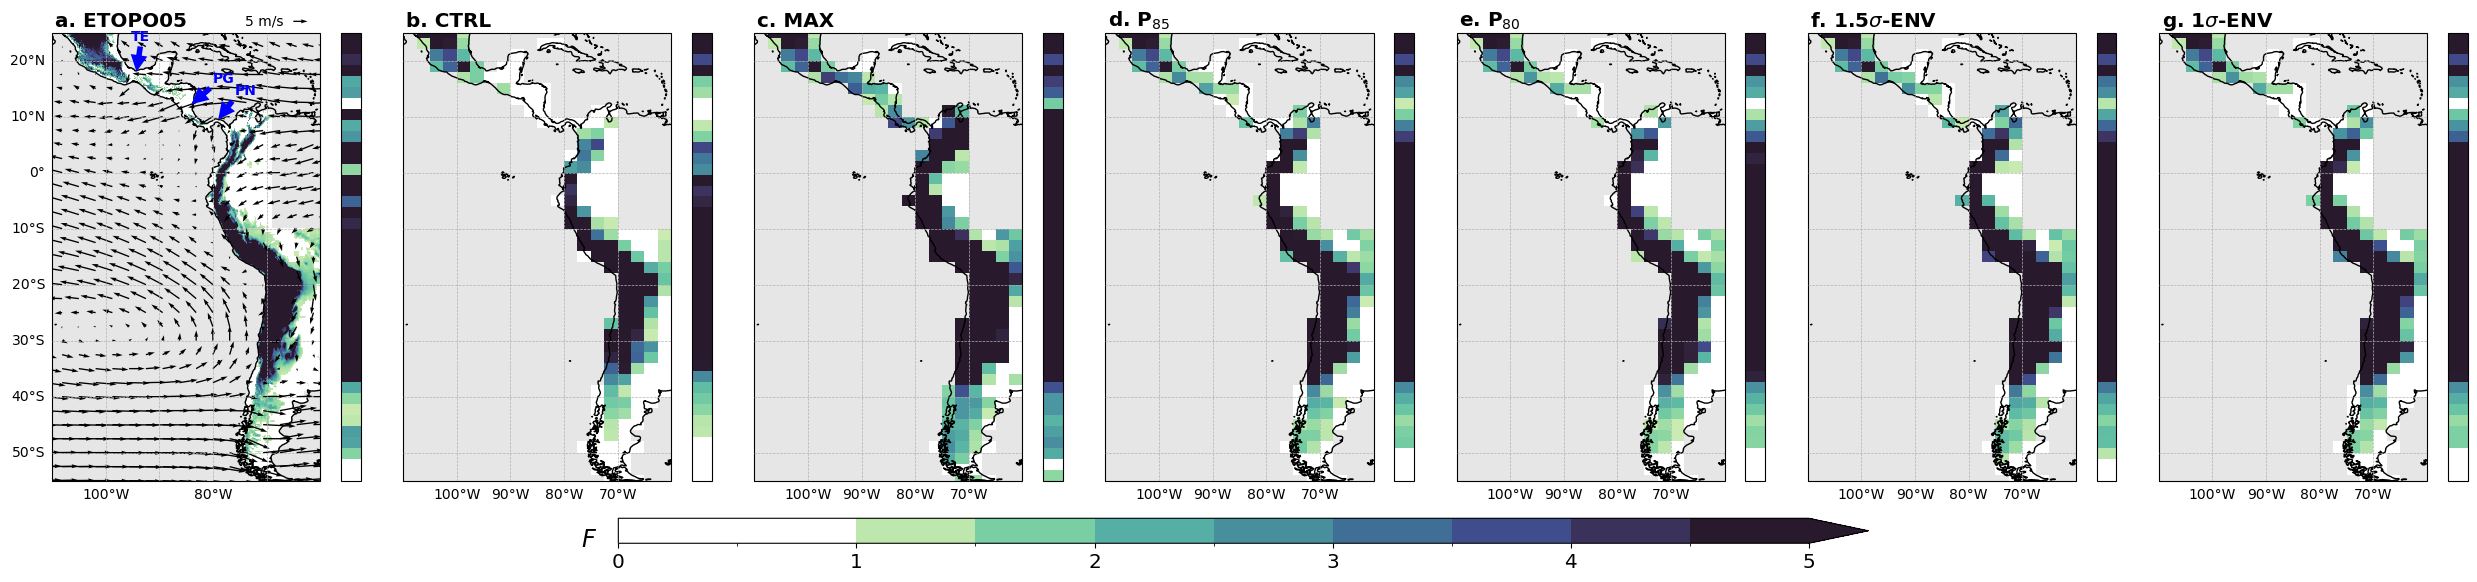

In [39]:
# -------------------- #
#       SETTINGS       #
# -------------------- #
text_kw={'color':'k', 'weight':'bold', 'size':'x-large', 'horizontalalignment':'left'}
arr_text_kw={'color':'blue', 'weight':'bold', 'size':'medium', 'horizontalalignment':'left', 'verticalalignment':'bottom'}
arrow_kw={'color':'blue', 'linewidth':.01, 'shrink':0.0}
# cmap specs
tcmap=cmo.deep
newcolors=tcmap(np.linspace(0.1, 1, 200))
white=np.repeat(np.array([[1, 1, 1, 1],[1, 1, 1, 1]]),25, axis=0)
cmap=ListedColormap(np.vstack((white, newcolors)))
vmin=0
vmax=5
# vector specs
skip_n=5
w=0.003
scalef=35
key_length=5
# map specs
trans=ccrs.PlateCarree()
proj=ccrs.PlateCarree()
map_bnds=[-110,-60,-55,25]
titles=[]

# -------------------- #
#          FIG         #
# -------------------- #
fig, ax = plt.subplots(nrows=1, ncols=21, figsize=(25,5),
                       layout='constrained',
                       subplot_kw={'projection':proj},
                       gridspec_kw={'width_ratios': [3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15, 3, 0.5, 0.15]}) #

## ETOPO Froude
ax[0].text(-109.5,26,'a. ETOPO05',**text_kw,zorder=100)
ax[0].pcolormesh(frObs_idx.lon, frObs_idx.lat, frObs.mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
q1=ax[0].quiver(u.lon[::skip_n], u.lat[::skip_n], u[::skip_n,::skip_n], v[::skip_n,::skip_n],
                 color='k', width=w, scale=scalef, scale_units='inches', units='height', transform=trans, zorder=10)
qk=ax[0].quiverkey(q1, .9, 1.025, key_length, rf'{key_length} m/s', labelcolor='k', labelpos='W')
ax[0].annotate('TE', xy=(-94.25,18), xytext=(-95.25,23), label='_Hidden', arrowprops=arrow_kw, **arr_text_kw, zorder=100)
ax[0].annotate('PG', xy=(-84,12.2), xytext=(-80,15.5), label='_Hidden', arrowprops=arrow_kw, **arr_text_kw, zorder=100)
ax[0].annotate('PN', xy=(-79,9.5), xytext=(-76,13.25), label='_Hidden', arrowprops=arrow_kw, **arr_text_kw, zorder=100)
ax[0].set(aspect='auto')
ax[0].coastlines(color='k')
ax[0].add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=0)
ax[0].add_feature(cfeature.LAND, fc=(0.9, 0.9, 0.9), zorder=0)
ax[0].set_extent(map_bnds, crs=trans)
gl=ax[0].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
gl.bottom_labels=True; gl.left_labels=True; gl.top_labels=False; gl.right_labels=False
gl.xformatter=LONGITUDE_FORMATTER
gl.yformatter=LATITUDE_FORMATTER
gl.xlabel_style={'color': 'black', 'weight': 'normal'}
gl.ylabel_style={'color': 'black', 'weight': 'normal'}
# heatmap
temp=frObs.mean(dim='month', skipna=True).interp_like(frGiss_lowres).max(dim='lon')
vec=np.flip(np.array([temp]))
frObs_zm=vec.reshape(vec.shape[1], 1)
sns.heatmap(frObs_zm, vmin=vmin, vmax=vmax, cmap=cmap, yticklabels=False, xticklabels=False, square=True, cbar=False, ax=ax[1])
ax[1].set(aspect=0.55)

ax[2].set_visible(False)
ax[5].set_visible(False)
ax[8].set_visible(False)
ax[11].set_visible(False)
ax[14].set_visible(False)
ax[17].set_visible(False)
ax[20].set_visible(False)

for i in [0,1,2,3,4,5]:
    axn=[3,6,9,12,15,18] #[2,4,6,8,10,12]
    n=axn[i]
    letter=['b. ','c. ','d. ','e. ','f. ','g. ', 'h. ', 'i. ']
    ax[n].text(-109.5,26,letter[i]+str(frGiss[i].source_id.values),**text_kw,zorder=100)
    
    ## plot Froude map
    ax[n].pcolormesh(frGiss_idx.lon, frGiss_idx.lat, frGiss_lowres[i].mean(dim='month'), cmap=cmap, vmin=vmin, vmax=vmax, transform=trans)
    ax[n].set(aspect='auto')
    ax[n].coastlines(color='k')
    ax[n].add_feature(cfeature.OCEAN, fc=(0.9, 0.9, 0.9), zorder=0)
    ax[n].add_feature(cfeature.LAND, fc=(0.9, 0.9, 0.9), zorder=0)
    ax[n].set_extent(map_bnds, crs=trans)
    gl=ax[n].gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
    gl.xlocator=mticker.FixedLocator([-100,-90,-80,-70])
    gl.bottom_labels=True; gl.left_labels=False; gl.top_labels=False; gl.right_labels=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'color': 'black', 'weight': 'normal'}
    gl.ylabel_style={'color': 'black', 'weight': 'normal'}
    
    ## plot max Froude heat map
    vec=np.flip(np.array([frGiss_lowres[i].mean(dim='month').max(dim='lon')]))
    frGiss_zm=vec.reshape(vec.shape[1], 1)
    sns.heatmap(frGiss_zm, vmin=vmin, vmax=vmax, cmap=cmap, yticklabels=False, xticklabels=False, square=True, cbar=False, ax=ax[n+1])
    ax[n+1].set(aspect=.55)

    
# add colorbar
levels=np.linspace(vmin, vmax, 11)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cax=fig.add_axes([.245, -0.075, 0.5, 0.05])
cbar=fig.colorbar(cf, orientation='horizontal', extend='max', cax=cax)
cbar.set_label('$F$', x=-0.025, labelpad=-32, rotation=0, size='xx-large', fontweight='bold', ha='center')
cbar.ax.tick_params(labelsize='x-large')
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('normal')

plt.savefig('froude_max_heatmap_850winds.pdf', transparent=True, bbox_inches='tight')